In [1]:
#parsing the whole of CAZy
import re

class CAZy_data:
    def __init__(self,filename1,filename2):
        self.data,self.acc,self.seq=[],[],[]
        with open(filename1,'r',encoding='utf-8') as inpt:
            for each in inpt:
                self.data.append(each.rstrip().split('$'))
                
        with open(filename2,'r',encoding='utf-8') as inpt1:
            for each1 in inpt1:
                if each1.startswith('>'):
                    self.acc.append(each1.rstrip())
                else:
                    self.seq.append(each1.rstrip())
            
                  
    def data_fetch(self,typ,position):
        typ_data=[]
        if typ=='all':
            typ_data=self.data
        else:
            for each in self.data:
                mult=each[position].split(' ')
                if len(mult)==1:#### In case typ = EC, Multi EC number and protein with no EC number are ignore.
                    if mult[0]==typ:
                        typ_data.append(each)
        return typ_data
    
    def EC_GH(self,ec_no,gh_fam):
        self.fasta=[]
        cazy_ec=self.data_fetch(ec_no,1)
        cazy_gh=self.data_fetch(gh_fam,-1)
        self.common_data=[[i[0],i[1],i[3],i[4],i[-2],i[-1]] for i in cazy_ec if i in cazy_gh]
        rm_prt, rm_prt_fasta=[],[]
        for each in range(len(self.common_data)):
            t=self.common_data[each]
            if self.prtn_filter(t[0]):
                all_acc=t[3].split(' ')
                if all_acc[0]!='':
                    for e_acc in all_acc:
                        e_seq=self.seq_fetch(e_acc)
                        try:
                            create_error=0/len(e_seq) # to remove accession number which doesnt have hits
                            self.fasta.append(f'>{e_acc}${t[0]}${t[1]}${t[2]}${t[-2]}${t[-1]}')
                            self.fasta.append(e_seq[0])
                        except ZeroDivisionError:
                            rm_prt_fasta.append(e_acc)
            else:
                rm_prt.append(t)
#         print('Total number of sequences:',len(self.fasta)/2)
#         print('Number of removed partial or fragment proteins (CAZy):',len(rm_prt))
#         print('Number of removed partial or fragment proteins (Fasta):',len(rm_prt_fasta))
        return self.fasta,rm_prt,rm_prt_fasta
    def prtn_filter(self,prt_name):
        hit=1
        if re.search('partial|fragment',prt_name.lower()):
            hit-=1
        return hit
            
    def seq_fetch(self,accession):
        hits=[]
        temp=0
        for each in range(len(self.acc)):
            if re.search(f'{accession}\D',self.acc[each]):
                temp+=1
                
                if self.prtn_filter(self.acc[each]): # remove partial| fragment accession numbers from GenBank description
                    hits.append(self.seq[each])
        if temp>1:
            print(f'Multiple hits for {accession}')
        elif temp==0:
            print(f'No hits for {accession}')
        return hits
     
In_data=CAZy_data('cazy_char_10_6_22.txt','char_gh_23_6_22.txt')


In [2]:
EC_number= input('please input the EC number (write all if no preference):')
GH_family= input('please input the GH family (write all if no preference):')


please input the EC number (write all if no preference):3.2.1.4
please input the GH family (write all if no preference):GH8


In [3]:
cazy_acc_seq,rm_cazy,rm_genbank=In_data.EC_GH(EC_number,GH_family) # write all to fetch all the EC number or all the GH family

No hits for NP_213966.1


In [73]:
import pandas as pd
import os
import numpy as np
import re
import matplotlib.pyplot as plt

In [5]:
#splitting sequence and accession IDs
acc,seq=[],[]
for ii in cazy_acc_seq:
    if ii.startswith('>'):
        acc.append(ii.rstrip())
    else:
        seq.append(ii.rstrip()) 

In [6]:
#creating a dictionary with only the reqiuired information with the accession ID
acc_seq={}
for i in range(len(acc)):
    accc=acc[i].split('$')
    acc_no=accc[0]
    x='>'+acc_no[1:]+'&'+accc[2]+'&'+accc[4]+'&'+accc[5]
    acc_seq[x] = seq[i]


In [7]:
#the file with the required info
filename='EC'+EC_number.split('.')[3]+'_'+GH_family+'.fasta'
y=len(seq)
with open(filename,'w',encoding='utf-8') as otp:
    for i in acc_seq.keys():
        seq=acc_seq.get(i)
        otp.write(i+'\n'+seq+'\n')

In [ ]:
#perform CD-hit step
identities=[0.9,0.8,0.7,0.6,0.5,0.4]
short_word=[5,5,5,4,3,2]
cd_hit_files=[]
for i in range(5):
    y=str(int(identities[i]*100))
    x='EC'+EC_number.split('.')[3]+'_'+GH_family+'_'+ y +'.fasta'
    cd_hit_files.append(x)
    cmd='cd-hit -i '+ filename + ' -o EC'+EC_number.split('.')[3]+'_'+GH_family+'_'+ y +'.fasta' + ' -c ' + str(identities[i]) +' -n ' + str(short_word[i])
    os.system(cmd)

In [19]:
#create a function to find outliers using IQR

def find_outliers_IQR(df):
    q1=df.quantile(0.25) #finding the first and 3rd quatrile
    q3=df.quantile(0.75)
    IQR=q3-q1 #finding the interquatrile range
    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))] #finding outliers
    return outliers

In [30]:
#cd_hit_files=['EC4_GH8_40.fasta','EC4_GH8_50.fasta', 'EC4_GH8_60.fasta', 'EC4_GH8_70.fasta', 'EC4_GH8_80.fasta', 'EC4_GH8_90.fasta']
for_hmm=[]
for file in cd_hit_files:
    acc,seq=[],[]
    with open(file,'r',encoding='utf-8') as fasta_file:
        #print(file)
        for ii in fasta_file:
            if ii.startswith('>'):
                acc.append(ii.rstrip())
            else:
                seq.append(ii.rstrip()) 
        acc_seq={}
        for i in range(len(acc)):
            accc=acc[i].split('$')
            acc_no=accc[0]
            acc_seq[acc_no[1:]] = seq[i]
        #print(acc_seq)
        acc_vs_seq=pd.DataFrame.from_dict(acc_seq, orient = 'index')
        acc_vs_seq.set_axis(['Sequence'], axis=1 , inplace=True)
        acc_vs_seq['Length']=np.nan
        for i in range(len(acc)): 
            acc_vs_seq.iloc[i,1]=int(len(acc_vs_seq.iloc[i,0]))
        filename1=file.split('.')[0]+'.csv'
        acc_vs_seq.to_csv(filename1)
        #finding out the outliers and removing them step follows
        acc_vs_seq=pd.read_csv(filename1) #read the csv file containing the length of each sequence as well, obtained from Get_EC_GH.ipynb
        acc_vs_seq.rename( columns={'Unnamed: 0':'ID'}, inplace=True ) #rename the unnamed column as ID
        x=list(find_outliers_IQR(acc_vs_seq['Length'])) #finding length outliers, saving them to list
        acc_vs_seq=acc_vs_seq[acc_vs_seq.Length.isin(x) == False] #removing the outlier. if the length is not in hte outlier list (x), they are taken
        acc_vs_seq.reset_index(inplace = True, drop = True) #resetting the index, as after dropping there are missing index values
        filename2= file.split('.')[0]+'_no_outliers.csv' #saving the updated csv file
        acc_vs_seq.to_csv(filename2)
        print('csv file with no outliers is successfully saved')
        #saving the sequences to multifasta
        xx=(acc_vs_seq.ID.count())
        filename3=file.split('.')[0]+'_no_outliers.fasta'
        for_hmm.append(filename3)
        with open(filename3,'w',encoding='utf-8') as otp:
            for i in range(xx):
                acc_id=acc_vs_seq.iloc[i,0]
                seq=acc_vs_seq.iloc[i,1]
                otp.write('>'+acc_id+'\n'+seq+'\n')
        print('multifasta file with no length outliers is successfully saved')


csv file with no outliers is successfully saved
multifasta file with no length outliers is successfully saved
csv file with no outliers is successfully saved
multifasta file with no length outliers is successfully saved
csv file with no outliers is successfully saved
multifasta file with no length outliers is successfully saved
csv file with no outliers is successfully saved
multifasta file with no length outliers is successfully saved
csv file with no outliers is successfully saved
multifasta file with no length outliers is successfully saved
csv file with no outliers is successfully saved
multifasta file with no length outliers is successfully saved


In [31]:
#making hmm for each cutoff
hmm_files=[]
for fas_for_hmm in for_hmm:
    print(fas_for_hmm)
    cmd_aln='mafft '+ fas_for_hmm + ' > ' +fas_for_hmm.split('.')[0]+'.aln'
    os.system(cmd_aln)
    print('alignment done for '+ fas_for_hmm)
    cmd_hmm='hmmbuild '+ fas_for_hmm.split('.')[0]+'.hmm ' + fas_for_hmm.split('.')[0]+'.aln'
    os.system(cmd_hmm)
    hmm_files.append(fas_for_hmm.split('.')[0]+'.hmm ')
    print('hmm build for '+ fas_for_hmm)

EC4_GH8_40_no_outliers.fasta
EC4_GH8_50_no_outliers.fasta
EC4_GH8_60_no_outliers.fasta
EC4_GH8_70_no_outliers.fasta
EC4_GH8_80_no_outliers.fasta
EC4_GH8_90_no_outliers.fasta


In [ ]:
search_file=input('file you would like to evaluate the HMMs against:')
#evaluation of HMMs
eval_files=[]
for hmm_file in hmm_files:
    xx=hmm_file.split('.')[0]+'_vs_'+search_file.split('.')[0]+'.txt'
    eval_files.append(xx)
    cmd_search='hmmsearch --noali --domtblout ' + hmm_file.split('.')[0]+'_vs_'+search_file.split('.')[0]+'.txt '+ hmm_file+search_file
    os.system(cmd_search)

C:\Users\ravis\anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


all ROC files saved


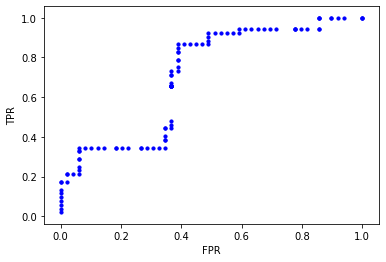

In [93]:
#eval_files=['EC4_GH8_40_no_outliers_vs_all_GH8.txt']
#making ROC curves
for eval_file in eval_files:
    use,no_use=[],[]
    with open(eval_file,'r',encoding='utf-8') as otp:
        for ii in otp:
            if ii.startswith('#'):
                #print(no_use)
                no_use.append(ii)
            else:
                #print(use)
                use.append(ii) 
    xx=len(use)
    with open('test_del.txt','w',encoding='utf-8') as otp:
        for i in range(xx):
            info=use[i]
            otp.write(info)
    import re
    new_data=[]
    for i in use:
        j=re.split('\s+',i.strip())
        new_data.append(j)
    df2=pd.DataFrame(new_data)
    df3=df2[[0,13,15,16,17,18,22]]
    df3.columns=['ID','Score','hmm_start','hmm_end','ali_start','ali_end','description']
    x=df3['description'].tolist()
    y=df3['ID'].tolist()
    filename4=eval_file.split('.')[0]+'_raw.csv'
    df3.to_csv(filename4)
    IDs=[]
    for i in range(len(x)):
        if x[i].startswith('-'):
            z=y[i]
            IDs.append(z)
        else:
            z=y[i]+x[i]
            IDs.append(z)
    df3['IDs']=IDs
    df3=df3.drop(['ID','description'], axis=1)
    df3.Score = df3.Score.astype(float)
    df3=df3.sort_values(by=['Score'], ascending=False)
    score=df3['Score'].to_list()
    data=df3['IDs'].to_list()
    TP,TN,FP,FN=[],[],[],[]
    for threshold in score:
        #print('threshold is ' + threshold)
        tp,fp=0,0
        fn,tn=0,0
        #print('loop1')
        for current_score in score:
            #print(current_score)
            #tp,fp=0,0
            #print('loop2')
            if float(current_score)>=float(threshold):
                #tp,fp=0,0
                #print('current score '+ current_score + ' is higher than threshold '+ threshold)
                #print('loop3')
                if EC_number in data[score.index(current_score)]:
                    #print('TP + 1')
                    tp=tp+1
                    #print(tp)
                    #print('loop4')
                else: 
                    #print('FP+1')
                    fp=fp+1
            else:
                #print('current score '+ current_score + ' is lower than threshold '+ threshold)
                if EC_number in data[score.index(current_score)]:
                    #print('FN + 1')
                    fn=fn+1
                else: 
                    #print('TN +1')
                    tn=tn+1
        TP.append(tp)
        FP.append(fp)
        FN.append(fn)
        TN.append(tn)
    #print(TP,TN,FP,FN)
    dff=pd.DataFrame()
    dff['Threshold']=score
    dff['TP']=TP
    dff['TN']=TN
    dff['FP']=FP
    dff['FN']=FN
    dff['FPR']=np.nan
    dff['TPR']=np.nan
    index=dff.index
    FPR,TPR=[],[]
    for i in index:
        tp=dff.iloc[i,1]
        tn=dff.iloc[i,2]
        fp=dff.iloc[i,3]
        fn=dff.iloc[i,4]
        fpr=fp/(fp+tn)
        tpr=tp/(tp+fn)
        FPR.append(fpr)
        TPR.append(tpr)
    dff['FPR']=FPR
    dff['TPR']=TPR
    filename5=eval_file.split('.')[0]+'_ROC.csv'
    dff.to_csv(filename5)
    plt.clf()
    plt.scatter(dff.FPR, dff.TPR, c ="blue", s=10)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    filename6=filename5.split('.')[0]+'.png'
    plt.savefig(filename6, dpi=300)
    
print('all ROC files saved')
